# Explorative Data Analysis 🐼

In [2]:
import gzip
from pathlib import Path
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## EDA Goals 📊
1. Traditional Data cleaning (outlier filtering, data characteristics, ...)
    - Too big data size, needa way to resolve this.
    - Depending on the question in interest (what business we want to look at, we can then say what state and data we are actually using because if we are looking at industry boom or restaurant boom, there may be differences) -> `Entertainment` + `Restaurant` + `Retail`
2. We need to merge the DataFrames to get what we need and identify questions we are interested in.
3. Need business analysis.
4. Need to find temporal pattern and correlated features (clustering?)
5. Make preprocessing pipeline / feature engineering.

# Question 🤔
We want to do reconmandation for business owner:
- We are doing the inverse thing: see what user like to make/develop our business towards that (先看客户，然后看开什么店好)
- Think from the business perspective.
- We can do one perspective then reverse it.
- If we are modeling interaction, what interaction are we modeling? All of these serve for **dynamic attributes modeling**
    - What is our `user`: gmap_id (lontitude and latitude)
    - What is our `item`: user_id (?)
    - What is `interactions`: Build connection by rating (num_reviews? token_counts_in_review? token_counts_pos_words?)

## Features 🤪
Static attributes (shove in a Factorized Machine to model latent between features):
1. location (longitude/latitude) (address?)
2. category (one hot)
3. price (discrete, need one hot)
4. hours (int)
5. MISC (one hot)
6. ...Text/reviews (text mining), definately useful to do, but require long time development

Dynamic attributes:
1. Models the interaction across time -> a latent representation (it is a feature)

## Prediction (Let's not do Dark Magic 🪄🧙）
**Predict unknown interaction between business and users.** New business in certain area, we predict the `overall` user metric (i.e. rating) for this new business (scoring function of your business).
- Predict the overall user metric of certain user with the item that does not exist.
- **If score of business is high, interacting with lcoal user (captured in data, think about A1 book_id and user_id), high rating tells about insights of successful business in theis region**.

1. user = `gmap_id`
2. model `interaction` with item = `user_id` through `metric` (counts/rating/...) and `features`.
    - Which business has close relationship for what user.

## Data Loader
Please do not push the data to Github (in .gitignore), this will result in large file issues. Actual data set is [here](https://cseweb.ucsd.edu/~jmcauley/datasets.html#google_local)

- For data efficiency, we will be using the 10-core data. A 2-degenerate graph: each vertex has at most two neighbors to its left, so the rightmost vertex of any subgraph has degree at most two. [Reference here](https://en.wikipedia.org/wiki/Degeneracy_(graph_theory))

- Let's use the small dataset for testing, using Hawaii dataset

- **Data**: Data itself.
    - The reviews provided by `users`, such as ratings, review text, and pictures.
    - Directly informs recommendations or sentiment analysis.
    - **Give what we are looking at from a user's perspective.**
- **MetaData**: Data that explains about the data.
    - `Business details`, such as name, address, average rating, category, and operational hours, describing the businesses associated with the reviews.
    - Enriches the analysis by providing business context.
    - **Extra information we can us  to perform joins.**

This takes about 3min to load in

In [3]:
def parseData(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    return data

base_path = Path.cwd().parent
file_path = base_path / "data" / "hawaii_data.json.gz"
meta_file_path = base_path / "data" / "hawaii_metadata.json.gz"

if file_path.exists():
    print(f"Loading data from: {file_path}")
    print(f"Loading metadata from: {meta_file_path}")
    metadata = parseData(meta_file_path)
    data = parseData(file_path)
    print(f"Loaded {len(data)} entries.")
    print(f"Loaded {len(metadata)} entries.")
else:
    print(f"File not found: {file_path}. Please ensure the file exists at the specified location.")

Loading data from: /Users/kevinb/Desktop/cse158/RDSB/data/data.json.gz
Loading metadata from: /Users/kevinb/Desktop/cse158/RDSB/data/metadata.json.gz
Loaded 1504347 entries.
Loaded 21507 entries.


This takes 3min to load into dataframe

In [4]:
df = pd.DataFrame(data)
meta_df = pd.DataFrame(metadata)
print("DataFrame created. Here's the structure:")
print(df.info())
print(meta_df.info())

DataFrame created. Here's the structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504347 entries, 0 to 1504346
Data columns (total 8 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1504347 non-null  object
 1   name     1504347 non-null  object
 2   time     1504347 non-null  int64 
 3   rating   1504347 non-null  int64 
 4   text     852596 non-null   object
 5   pics     132702 non-null   object
 6   resp     108799 non-null   object
 7   gmap_id  1504347 non-null  object
dtypes: int64(2), object(6)
memory usage: 91.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21507 entries, 0 to 21506
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              21503 non-null  object 
 1   address           21189 non-null  object 
 2   gmap_id           21507 non-null  object 
 3   description       5774 non-null   object 
 4   latit

# Data Type Conversion

In [5]:
# Convert to seconds if timestamps are in milliseconds
df['time'] = df['time'] / 1000
df['time'] = pd.to_datetime(df['time'], unit='s', errors='coerce')  # Use errors='coerce' to handle invalid timestamps

# Outliers (Need to work on this)

In [6]:
def detect_outliers(column, df):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

num_of_reviews_outliers = detect_outliers('num_of_reviews', meta_df)
print(num_of_reviews_outliers.shape, meta_df.shape)

(2834, 15) (21507, 15)


Remove outliers from the DataFrame

In [7]:
Q1 = meta_df['num_of_reviews'].quantile(0.25)
Q3 = meta_df['num_of_reviews'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_df = meta_df.filter(
    items=meta_df[(meta_df['num_of_reviews'] >= lower_bound) & (meta_df['num_of_reviews'] <= upper_bound)].index,
    axis=0
)

filtered_df.shape, meta_df.shape

((18673, 15), (21507, 15))

In [8]:
meta_df = filtered_df

# Some Visualization
Time distribution and Rating distribution

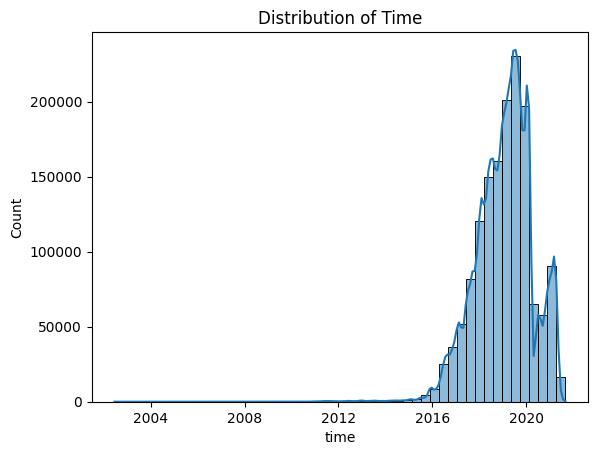

In [9]:
sns.histplot(df['time'], bins=50, kde=True)
plt.title('Distribution of Time')
plt.show()

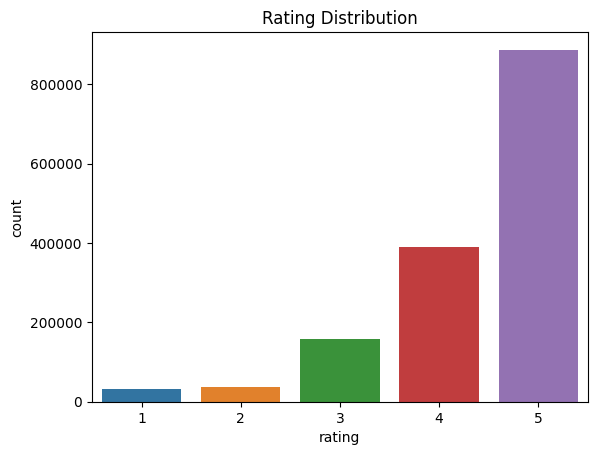

In [10]:
sns.countplot(x='rating', data=df)
plt.title('Rating Distribution')
plt.show()

We should not predict rating? This imbalance would be really hard to deal with.

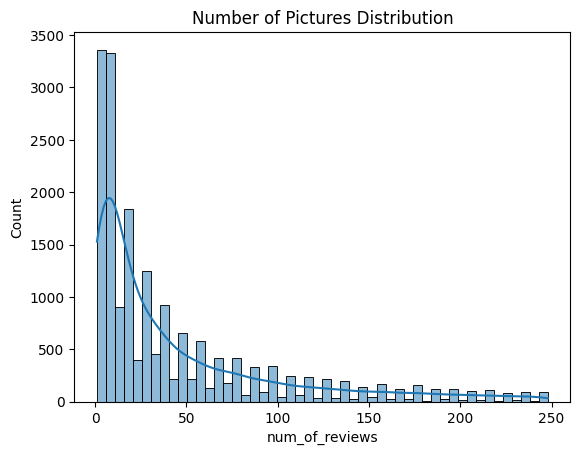

In [11]:
sns.histplot(meta_df['num_of_reviews'], bins=50, kde=True)
plt.title('Number of Pictures Distribution')
plt.show()

#  Merging
Metadata provide inofrmation about business, merge on `gmap_id` would be fine.

In [12]:
merged_df = df.merge(meta_df, on='gmap_id', how='inner')
print(merged_df.shape)

(379733, 22)


In [13]:
merged_df.rename(columns={'time_x': 'time', 'rating_x': 'rating', 'name_x': 'u_name', 'name_y': 'b_name'}, inplace=True)

In [14]:
merged_df.columns

Index(['user_id', 'u_name', 'time', 'rating', 'text', 'pics', 'resp',
       'gmap_id', 'b_name', 'address', 'description', 'latitude', 'longitude',
       'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC',
       'state', 'relative_results', 'url'],
      dtype='object')

# Business Popularity Analysis

Reviews trend for top businesses

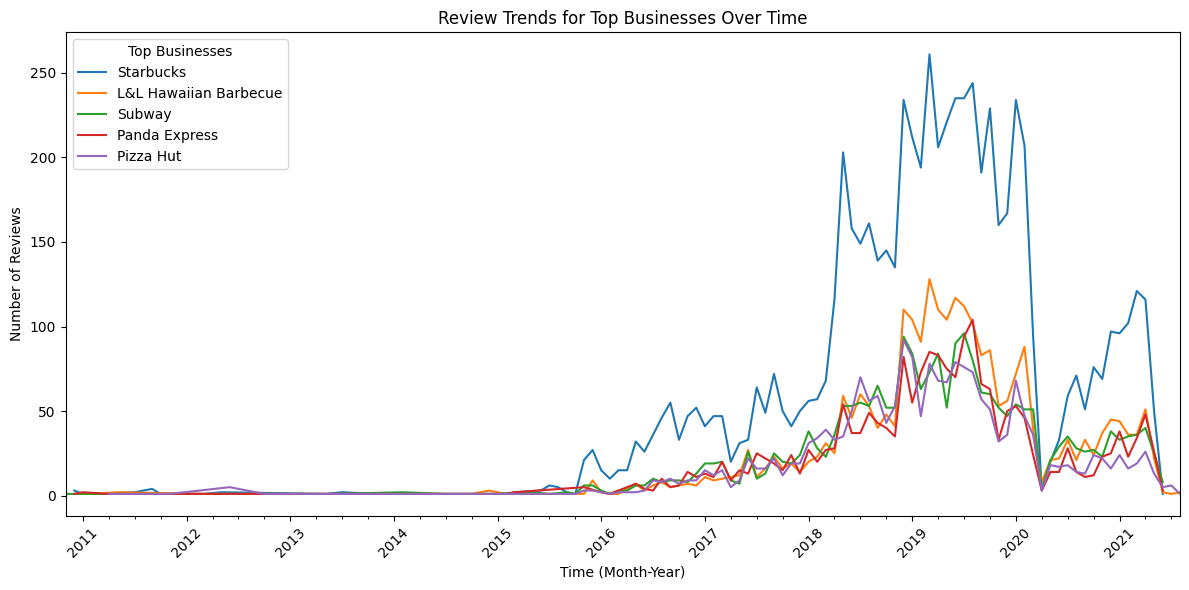

In [111]:
# Get the top 5 businesses by review count
top_businesses = merged_df['b_name'].value_counts().head(5).index

plt.figure(figsize=(12, 6))
for business in top_businesses:
    business_reviews = merged_df[merged_df['b_name'] == business].groupby(
        merged_df['time'].dt.to_period('M')
    ).size()
    business_reviews.plot(label=business)

plt.title('Review Trends for Top Businesses Over Time')
plt.xlabel('Time (Month-Year)')
plt.ylabel('Number of Reviews')
plt.legend(title="Top Businesses")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


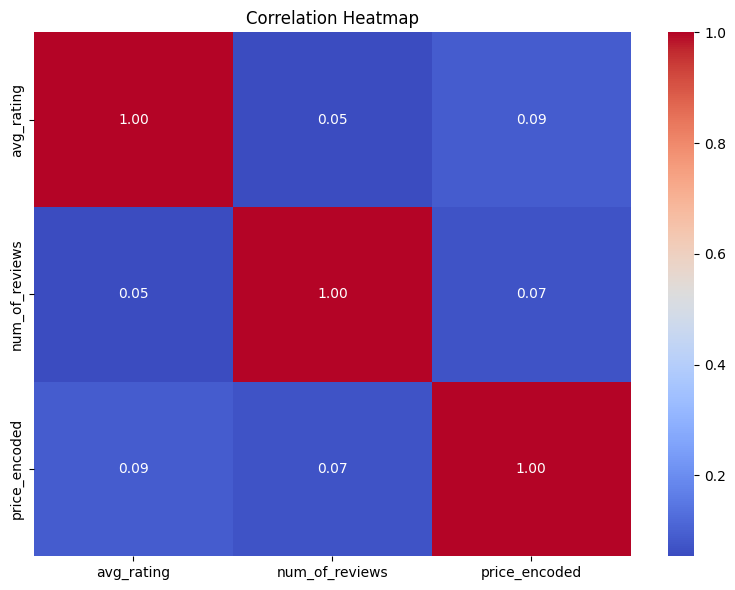

In [112]:
# Select relevant numerical columns
numeric_data = merged_df[['avg_rating', 'num_of_reviews']]

# Add a numeric encoding for 'price' if available (e.g., "$", "$$")
if 'price' in merged_df.columns:
    merged_df['price_encoded'] = merged_df['price'].apply(
        lambda x: len(str(x)) if isinstance(x, str) else None
    )
    numeric_data['price_encoded'] = merged_df['price_encoded']

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


## Category popularity based on rating sums

Convert 'category' and 'address' columns to strings

In [ ]:
merged_df['category'] = merged_df['category'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
merged_df['address'] = merged_df['address'].apply(lambda x: str(x) if not isinstance(x, str) else x)

Only most popular categories by total review count (using the sum of rating here)

In [129]:
popular_categories = merged_df.groupby('category')['rating'].sum().sort_values(ascending=False).head(10).index
filtered_df = merged_df[merged_df['category'].isin(popular_categories)]

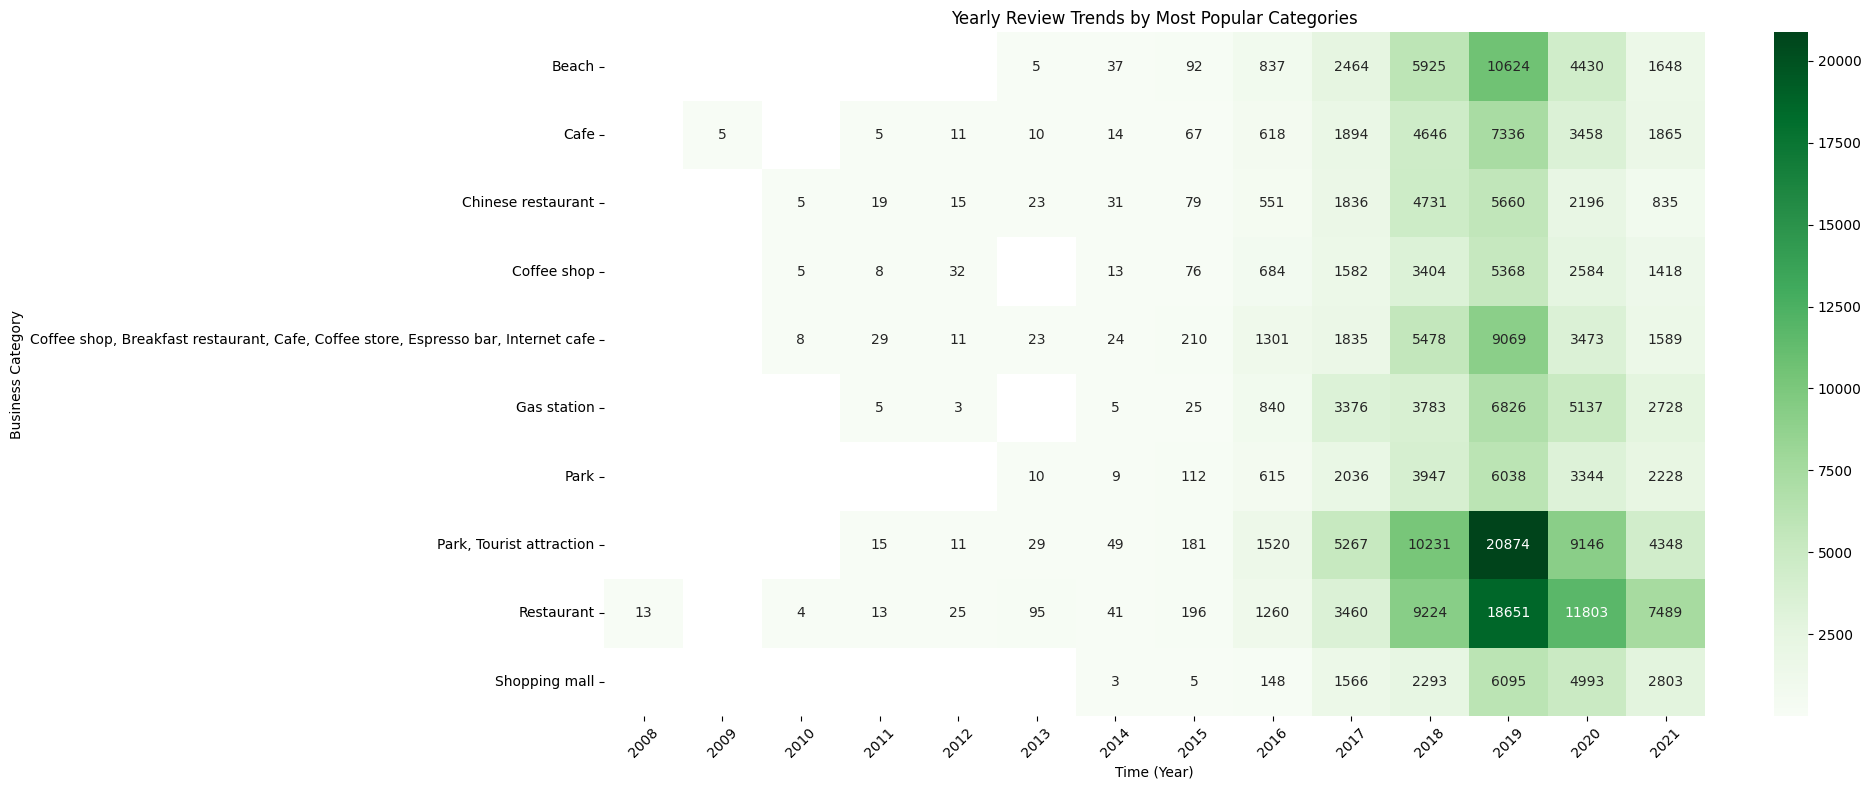

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by year and category for rating sum
review_trends_popular = filtered_df.groupby([filtered_df['time'].dt.to_period('Y'), 'category'])['rating'].sum().unstack()

plt.figure(figsize=(20, 8))
sns.heatmap(review_trends_popular.T, cmap="Greens", annot=True, fmt="g")
plt.title('Yearly Review Trends by Most Popular Categories')
plt.xlabel('Time (Year)')
plt.ylabel('Business Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Rating popularity based on counts
Rating here doesn't matter at retreieval, just for counting, check trends in rating across time.
- People seems to give 5

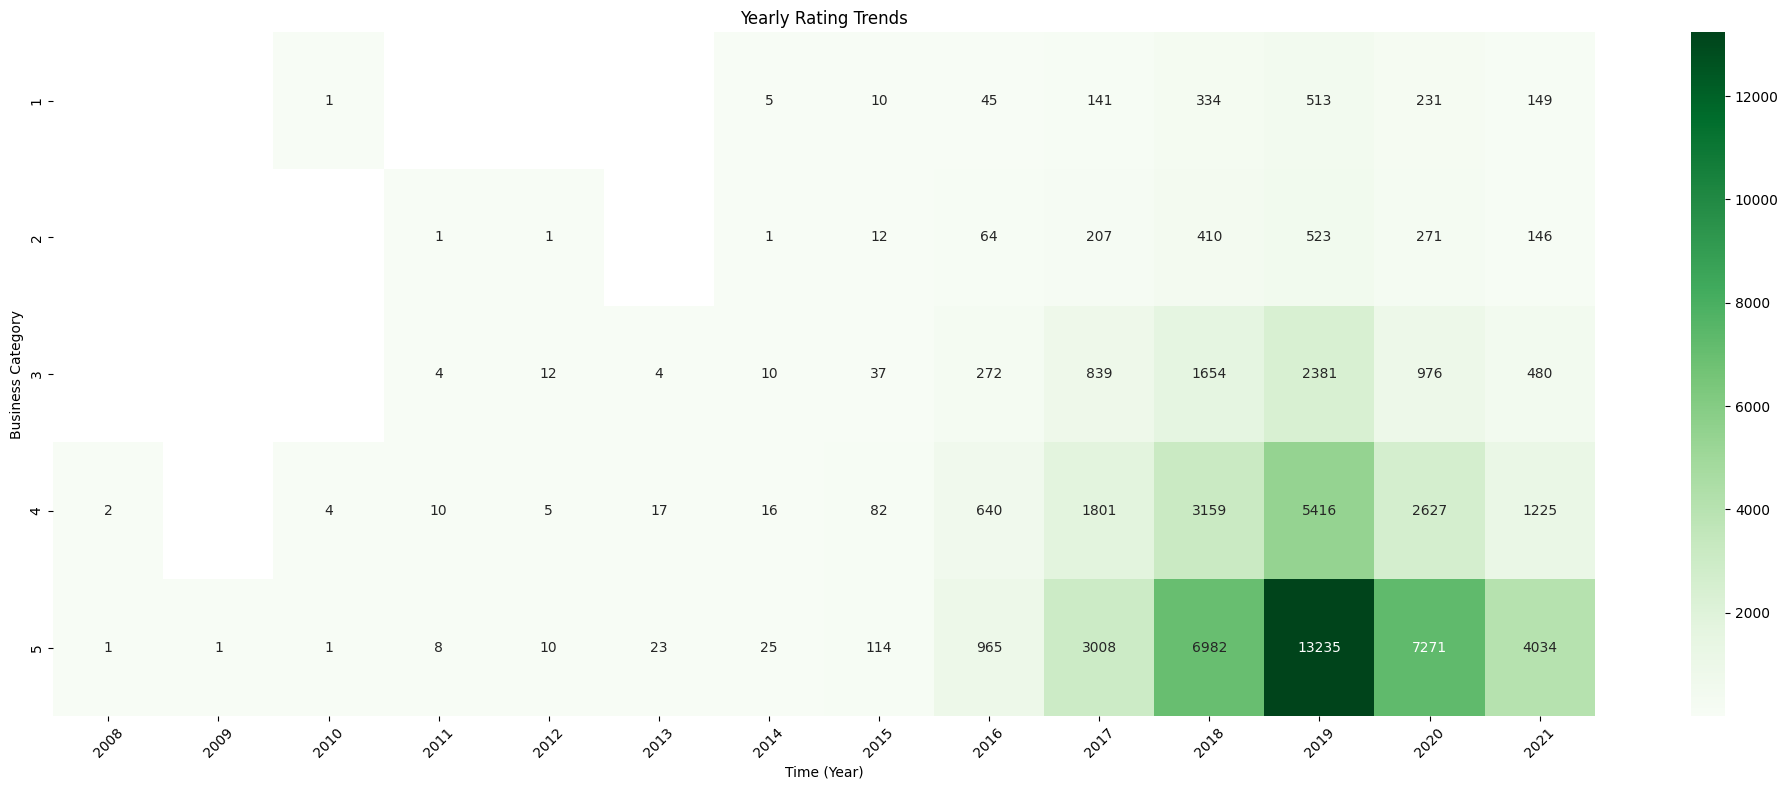

In [139]:
rating_trends_popular = merged_df.groupby([filtered_df['time'].dt.to_period('Y'), 'rating'])['rating'].count().unstack()

plt.figure(figsize=(20, 8))
sns.heatmap(rating_trends_popular.T, cmap="Greens", annot=True, fmt="g")
plt.title('Yearly Rating Trends')
plt.xlabel('Time (Year)')
plt.ylabel('Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Popularity based on rating by address

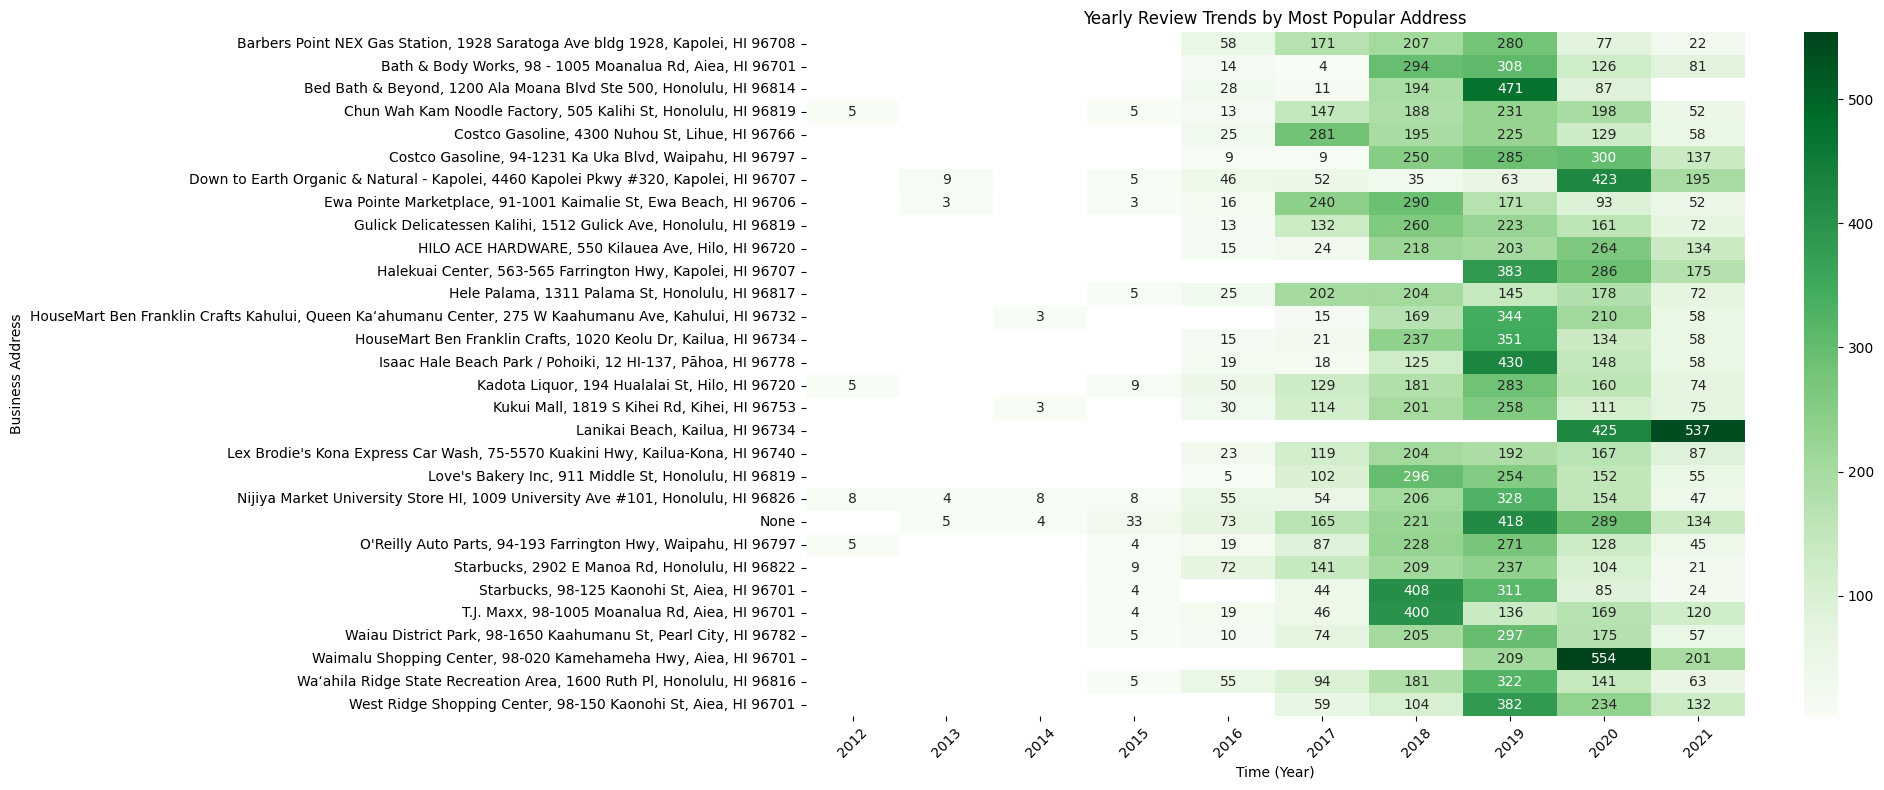

In [147]:
popular_address = merged_df.groupby('address')['rating'].sum().sort_values(ascending=False).head(30).index
filtered_df = merged_df[merged_df['address'].isin(popular_address)]
review_trends_popular = filtered_df.groupby([filtered_df['time'].dt.to_period('Y'), 'address'])['rating'].sum().unstack()

plt.figure(figsize=(20, 8))
sns.heatmap(review_trends_popular.T, cmap="Greens", annot=True, fmt="g")
plt.title('Yearly Review Trends by Most Popular Address')
plt.xlabel('Time (Year)')
plt.ylabel('Business Address')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Clustering Analysis

In [155]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import geopandas as gpd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

## Rating/Reviews Clustering
Clustering businesses based on average rating and number of reviews

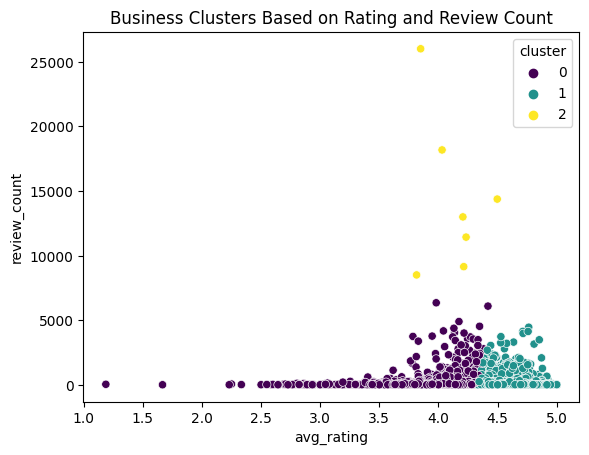

In [54]:
business_data = merged_df.groupby('b_name').agg({'rating': 'mean', 'user_id': 'count'}).reset_index()
business_data.columns = ['name', 'avg_rating', 'review_count']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(business_data[['avg_rating', 'review_count']])

kmeans = KMeans(n_clusters=3, random_state=42)
business_data['cluster'] = kmeans.fit_predict(scaled_data)

sns.scatterplot(x='avg_rating', y='review_count', hue='cluster', data=business_data, palette='viridis')
plt.title('Business Clusters Based on Rating and Review Count')
plt.show()

## Geographical Clustering

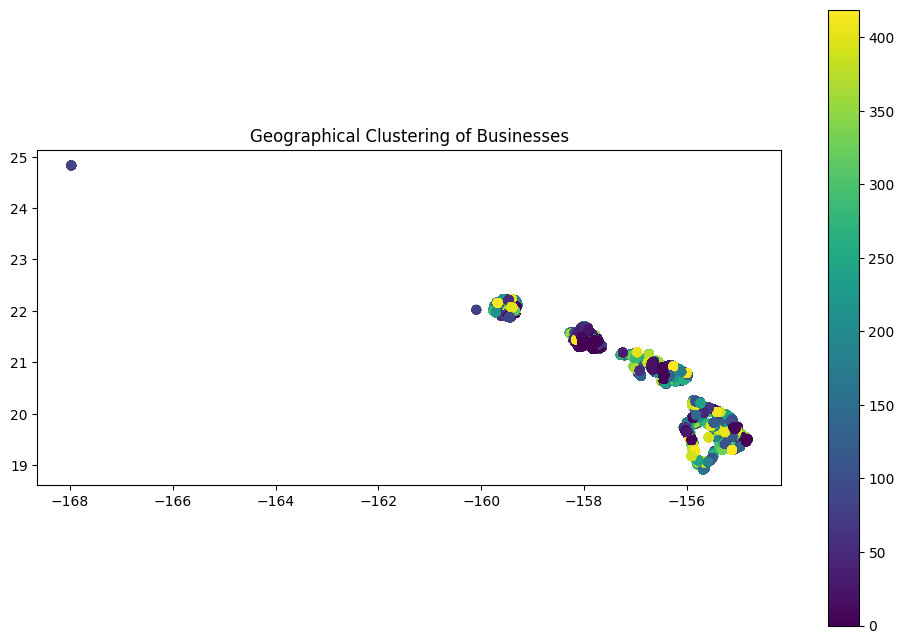

In [154]:
geo_features = merged_df[['latitude', 'longitude']].dropna()
dbscan = DBSCAN(eps=0.01, min_samples=10, metric='haversine').fit(geo_features)
merged_df['geo_cluster'] = dbscan.labels_

gdf = gpd.GeoDataFrame(
    merged_df, geometry=gpd.points_from_xy(merged_df['longitude'], merged_df['latitude'])
)

gdf.plot(column='geo_cluster', cmap='viridis', legend=True, figsize=(12, 8))
plt.title('Geographical Clustering of Businesses')
plt.show()

## Review Behavior Clusters

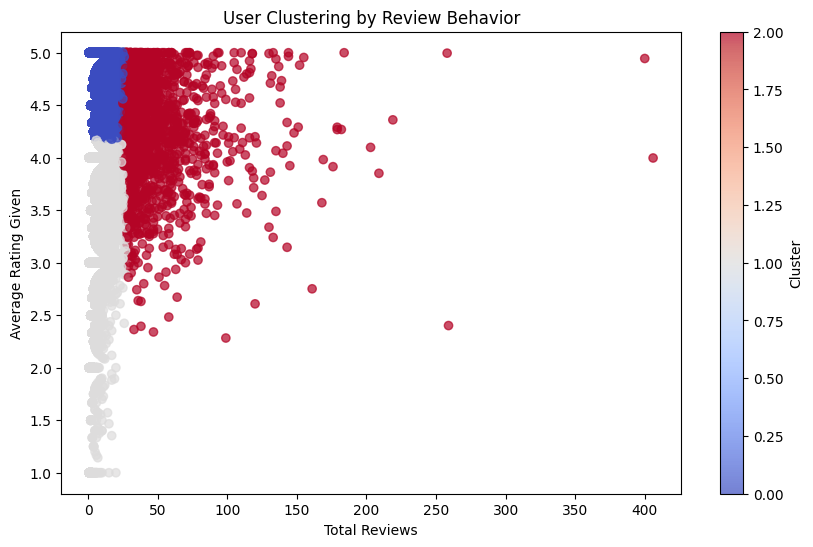

In [162]:
# Aggregate user statistics
user_stats = merged_df.groupby('user_id').agg(
    total_reviews=('rating', 'count'),
    avg_rating=('rating', 'mean')
).dropna()
scaled_user_stats = scaler.fit_transform(user_stats)

kmeans = KMeans(n_clusters=3, random_state=42)
user_clusters = kmeans.fit_predict(scaled_user_stats)
user_stats['cluster'] = user_clusters

plt.figure(figsize=(10, 6))
plt.scatter(user_stats['total_reviews'], user_stats['avg_rating'], c=user_clusters, cmap='coolwarm', alpha=0.7)
plt.title('User Clustering by Review Behavior')
plt.xlabel('Total Reviews')
plt.ylabel('Average Rating Given')
plt.colorbar(label='Cluster')
plt.show()


## Clustering Based on Text Habit

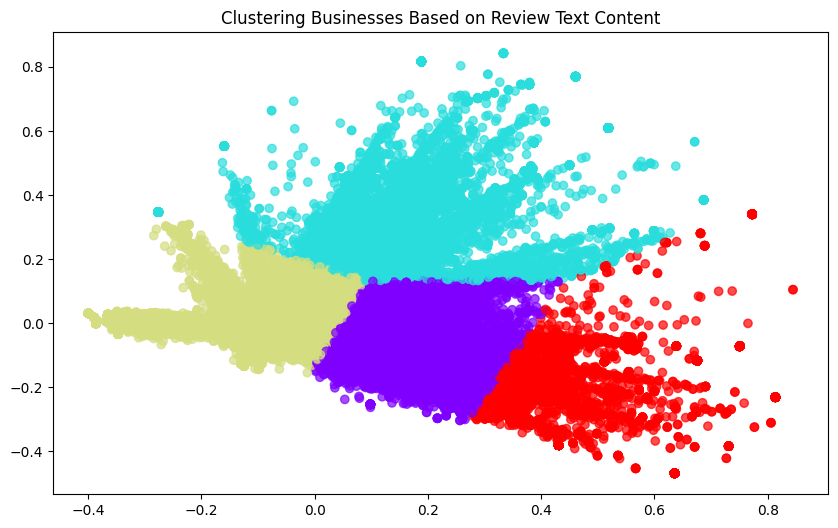

In [156]:
# Vectorize review text
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
text_features = vectorizer.fit_transform(merged_df['text'].dropna())

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(text_features.toarray())
text_kmeans = KMeans(n_clusters=4, random_state=42)
text_clusters = text_kmeans.fit_predict(reduced_features)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=text_clusters, cmap='rainbow', alpha=0.7)
plt.title('Clustering Businesses Based on Review Text Content')
plt.show()

Something in text that we may be able to use, some hidden pattern.

## Temporal Review Counts Clustering Based on Category

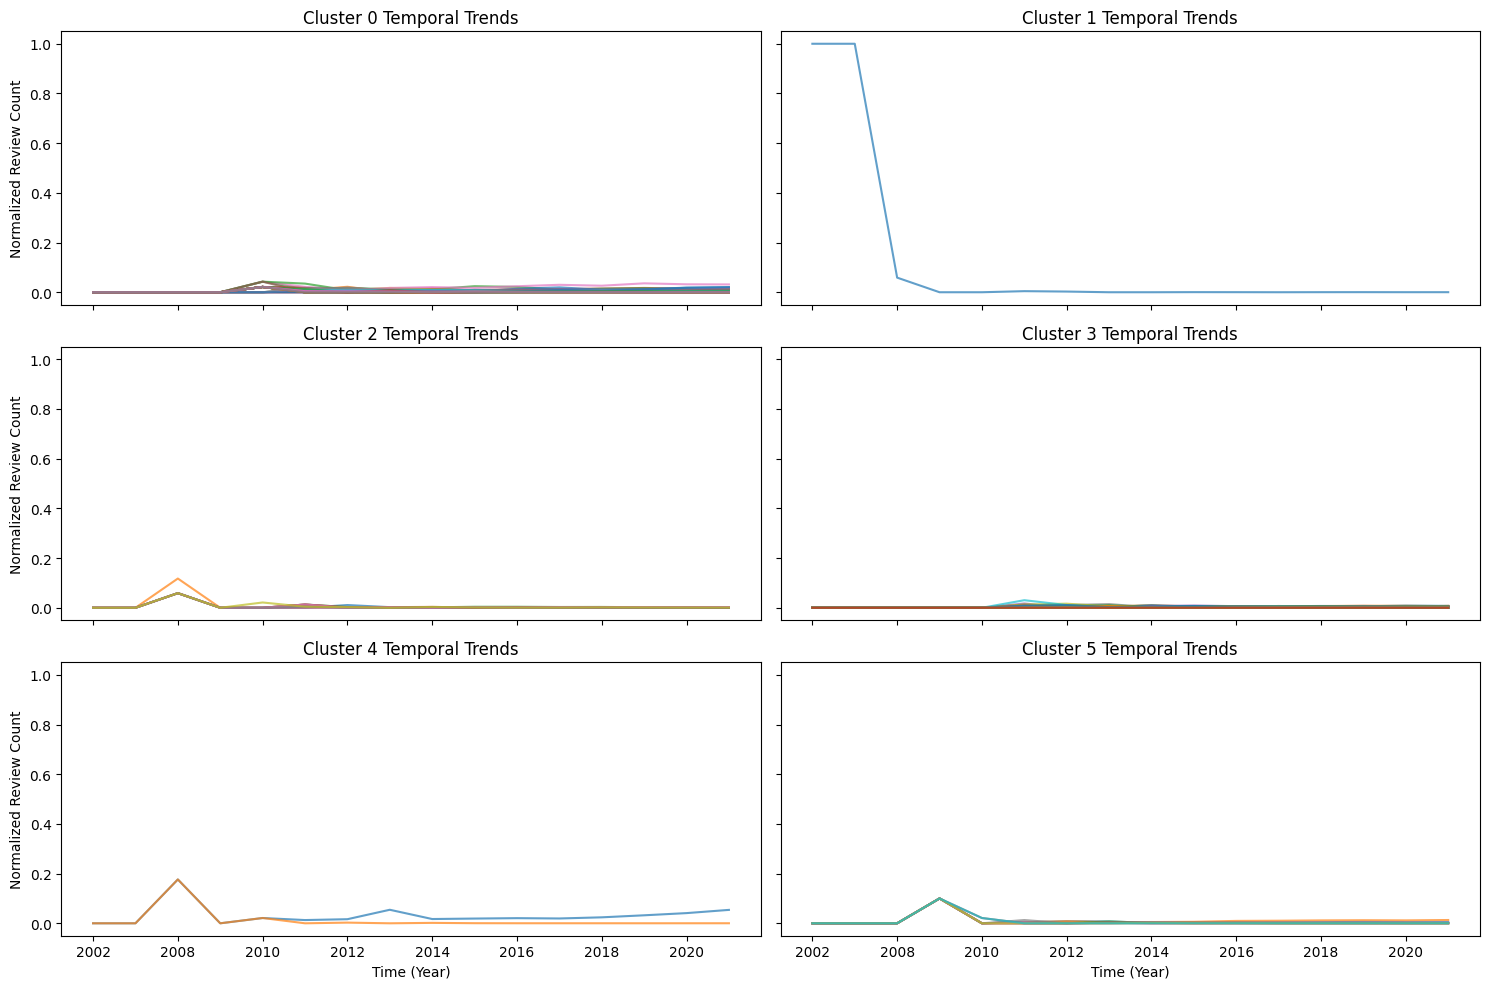

In [178]:
# Group data by category and time (e.g., yearly review counts)
temporal_data = merged_df.groupby([merged_df['time'].dt.to_period('Y'), 'category'])['rating'].count().unstack(fill_value=0)

temporal_data_normalized = temporal_data.div(temporal_data.sum(axis=1), axis=0).fillna(0).T
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(temporal_data_normalized)
temporal_data_normalized['cluster'] = clusters

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for cluster_id, ax in enumerate(axes):
    cluster_data = temporal_data_normalized[temporal_data_normalized['cluster'] == cluster_id].drop(columns='cluster')
    
    cluster_data.T.plot(ax=ax, legend=False, alpha=0.7)
    ax.set_title(f'Cluster {cluster_id} Temporal Trends')
    ax.set_xlabel('Time (Year)')
    ax.set_ylabel('Normalized Review Count')

plt.tight_layout()
plt.show()

Automatica aribitarty cluster seem to have temporal pattern hidden in the category